In [1]:
from typing import Union, Self
from numbers import Number
from itertools import chain, product

import numpy as np
import sympy as sp
import cvxpy as cp

import scipy
from scipy.sparse import csr_matrix
import scipy.sparse as sparse
from scipy.linalg import qr
from scipy.sparse import coo_matrix, csc_matrix
from scipy.sparse.linalg import splu, svds
from sksparse.cholmod import cholesky

from bmn.algebra import MatrixOperator, SingleTraceOperator, MatrixSystem
from bmn.linear_algebra import get_null_space, create_sparse_matrix_from_dict, is_in_row_space, get_row_space
from bmn.bootstrap import BootstrapSystem
from bmn.solver import minimal_eigval, sdp_init, sdp_relax, sdp_minimize, minimize, get_quadratic_constraint_vector
from bmn.brezin import compute_Brezin_energy, compute_Brezin_energy_Han_conventions

from bmn.debug_utils import disable_debug

np.set_printoptions(linewidth=120)  # Adjust the number to the desired width

# plot settings
import matplotlib.pyplot as plt
import matplotlib
from cycler import cycler

plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.major.size'] = 5.0
plt.rcParams['xtick.minor.size'] = 3.0
plt.rcParams['ytick.major.size'] = 5.0
plt.rcParams['ytick.minor.size'] = 3.0
plt.rcParams['lines.linewidth'] = 2
plt.rc('font', family='serif',size=16)
matplotlib.rc('text', usetex=True)
matplotlib.rc('legend', fontsize=16)
matplotlib.rcParams['axes.prop_cycle'] = cycler(
    color=['#E24A33', '#348ABD', '#988ED5', '#777777', '#FBC15E', '#8EBA42', '#FFB5B8']
    )
matplotlib.rcParams.update(
    {"axes.grid":True,
    "grid.alpha":0.75,
    "grid.linewidth":0.5}
    )
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

## One Matrix Model

In [2]:
matrix_system = MatrixSystem(
    #operator_basis=['X', 'P'],
    operator_basis=['X', 'Pi'],
    commutation_rules_concise = {
        #('P', 'X'): -1j,
        ('Pi', 'X'): 1, # use Pi' = i P to ensure reality
    },
    #hermitian_dict={'P': True, 'X': True},
    hermitian_dict={'Pi': False, 'X': True},
)

# scale variables as P = sqrt(N) P', X = sqrt(N) X'
hamiltonian = SingleTraceOperator(
        #data={("P", "P"): 1, ("X", "X"): 1, ("X", "X", "X", "X"): 7}
        data={("Pi", "Pi"): -1, ("X", "X"): 1, ("X", "X", "X", "X"): 1e-4}
    )

# <tr G O > = 0 might need to be applied only for O with deg <= L-2
#gauge = MatrixOperator(data={('X', 'P'): 1j, ('P', 'X'): -1j, ():1})
gauge = MatrixOperator(data={('X', 'Pi'): 1, ('Pi', 'X'): -1, ():1})

bootstrap = BootstrapSystem(
    matrix_system=matrix_system,
    hamiltonian=hamiltonian,
    gauge=gauge,
    half_max_degree=3,
    odd_degree_vanish=False
)

Assuming all operators are either Hermitian or anti-Hermitian.


In [ ]:
bootstrap.build_linear_constraints()

## Scan

In [7]:
disable_debug()

g_values = np.linspace(0.1, 4, 10)
#g_values = [1 for i in range(2)]

init = None
#init = np.ones(26)
L = 2

results = {
    'g': g_values,
    'param': [],
    'energy': [],
    'x^2': [],
    'success': [],
    }

for g in g_values:

    matrix_system = MatrixSystem(
        #operator_basis=['X', 'P'],
        operator_basis=['X', 'Pi'],
        commutation_rules_concise = {
            #('P', 'X'): -1j,
            ('Pi', 'X'): 1, # use Pi' = i P to ensure reality
        },
        #hermitian_dict={'P': True, 'X': True},
        hermitian_dict={'Pi': False, 'X': True},
    )

    # scale variables as P = sqrt(N) P', X = sqrt(N) X'
    hamiltonian = SingleTraceOperator(
            #data={("P", "P"): 1, ("X", "X"): 1, ("X", "X", "X", "X"): 7}
            data={("Pi", "Pi"): -1, ("X", "X"): 1, ("X", "X", "X", "X"): g}
        )

    # <tr G O > = 0 might need to be applied only for O with deg <= L-2
    #gauge = MatrixOperator(data={('X', 'P'): 1j, ('P', 'X'): -1j, ():1})
    gauge = MatrixOperator(data={('X', 'Pi'): 1, ('Pi', 'X'): -1, ():1})

    bootstrap = BootstrapSystem(
        matrix_system=matrix_system,
        hamiltonian=hamiltonian,
        gauge=gauge,
        half_max_degree=L,
        odd_degree_vanish=True
    )

    param, success = minimize(
        bootstrap=bootstrap,
        op=bootstrap.hamiltonian,
        maxiters=25,
        #init=init,
        verbose=False
        )

    op = bootstrap.hamiltonian
    vec = bootstrap.single_trace_to_coefficient_vector(op, return_null_basis=True)
    energy = vec.dot(param)

    op = SingleTraceOperator(
        data={("X", "X"): 1}
        )
    vec = bootstrap.single_trace_to_coefficient_vector(op, return_null_basis=True)
    x2 = vec.dot(param)

    results['param'].append(param)
    results['success'].append(success)
    results['energy'].append(energy)
    results['x^2'].append(x2)

Assuming all operators are either Hermitian or anti-Hermitian.
generated 9 Hamiltonian constraints
generated 7 gauge constraints
generated 21 reality constraints
generated 10 odd degree vanish constraints
param_dim_null = 8
constraint from operator_idx = 17 is quadratically trivial.
constraint from operator_idx = 28 is quadratically trivial.


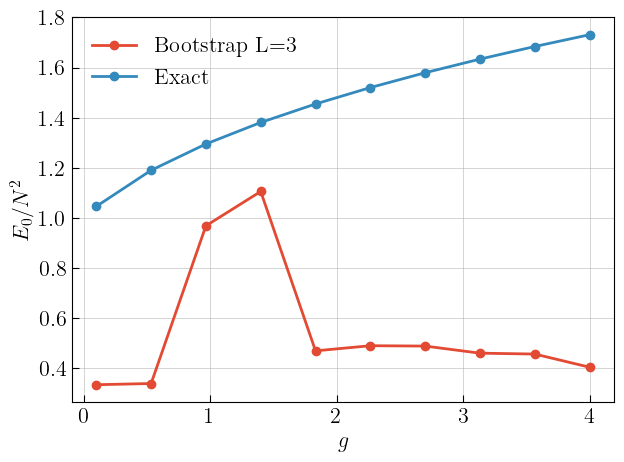

In [ ]:
# compute the exact values (note the difference in conventions)
exact_values = [compute_Brezin_energy_Han_conventions(g) for g in g_values]

fig, ax = plt.subplots(figsize=(7,5))
ax.plot(results['g'], results['energy'], '-o', label=f'Bootstrap L={bootstrap.half_max_degree}')
ax.plot(results['g'], exact_values, '-o', label=f'Exact')

for i in range(len(g_values)):
    if results['success'][i]:
        print(results['g'][i], results['energy'][i])
        ax.scatter(
            results['g'][i],
            results['energy'][i],
            color='k',
            zorder=10,
            label=f'Bootstrap L={bootstrap.half_max_degree}, converged'
            )

ax.legend(frameon=False)
ax.set_xlabel(r"$g$")
ax.set_ylabel(r"$E_0/N^2$")
plt.show()

In [ ]:
for success, p in zip(results['success'], results['param']):
    if success:
        print(p)

In [ ]:
np.random.normal(size=8)

In [ ]:
# compare against Table 3 in Brezin et al
table_values = {
    0.01: 5.05,
    0.1: 0.542,
    0.5: 0.651,
    1: 0.740,
    50: 2.217,
    #1000: 5.915, # for this extreme value the code fails
    }

for g, table_val in table_values.items():
    print(f"g = {g}, table 3 value = {table_val}, computed value = {compute_energy(g):.03f}")

In [ ]:

fig, ax = plt.subplots(figsize=(7,5))

g_values = np.linspace(0.01, 4, 20)
exact_energies = np.asarray([compute_energy(g) for g in g_values])
ax.plot(g_values, exact_energies, '-o')

g_values = 0.5 * np.linspace(0.01, 4, 20)
exact_energies = np.asarray([compute_energy(g) for g in g_values])
ax.plot(g_values * 2, 2 * exact_energies, '-o')

ax.set_xlabel(r"$g$")
ax.set_ylabel(r"$E_0/N^2$")
plt.show()

In [ ]:
compute_energy(0.1)

In [ ]:
fermi_level_integral(sol.root, g)

In [ ]:
fermi_level_integrand(0.2, 0.1, 1), energy_integrand(0.2, 0.1, 1)

In [ ]:
fermi_level_integral(0.2, 1), energy_integral(0.2, 1)

In [ ]:


# Step 3: Define the function to find the root of
def equation_to_solve(c, a, b):
    return integral(c, a, b) - 1

# Define the limits of integration
a = 0  # Replace with your lower limit
b = 1  # Replace with your upper limit

# Step 4: Use a root-finding algorithm to find the root of equation_to_solve
sol = root_scalar(equation_to_solve, args=(a, b), bracket=[0, 10], method='brentq')

if sol.converged:
    print(f'The root c is: {sol.root}')
else:
    print('The root-finding did not converge')


In [ ]:
results['success']

## OLD

In [ ]:
nu = 1.0

matrix_system = MatrixSystem(
    operator_basis=['X0', 'X1', 'X2', 'P0', 'P1', 'P2'],
    commutation_rules_concise = {
        ('P0', 'X0'): -1j,
        ('P1', 'X1'): -1j,
        ('P2', 'X2'): -1j,
    }
)

# scale variables as P = sqrt(N) P', X = sqrt(N) X'
hamiltonian = SingleTraceOperator(
        data={
           # kinetic term
            ("P0", "P1"): 1,
            ("P1", "P1"): 1,
            ("P1", "P1"): 1,
            # quadratic term
            ('X0', 'X0'): nu**2 / 2,
            ('X1', 'X1'): nu**2 / 2,
            ('X2', 'X2'): nu**2 / 2,
            # cubic term
            ('X0', 'X1', 'X2'): 6 * 1j * nu,
            # quadratic term (XY)
            ('X0', 'X1', 'X0', 'X1'): - 1/4,
            ('X1', 'X0', 'X1', 'X0'): -1/4,
            ('X0', 'X1', 'X1', 'X0'): 1/4,
            ('X1', 'X0', 'X0', 'X1'): 1/4,
            # quadratic term (XZ) TODO check sign
            ('X0', 'X2', 'X0', 'X2'): - 1/4,
            ('X2', 'X0', 'X2', 'X0'): -1/4,
            ('X0', 'X2', 'X2', 'X0'): 1/4,
            ('X2', 'X0', 'X0', 'X2'): 1/4,
            # quadratic term (YZ)
            ('X1', 'X2', 'X1', 'X2'): - 1/4,
            ('X2', 'X1', 'X2', 'X1'): -1/4,
            ('X1', 'X2', 'X2', 'X1'): 1/4,
            ('X2', 'X1', 'X1', 'X2'): 1/4,
            }
            )

# <tr G O > = 0 might need to be applied only for O with deg <= L-2
gauge = MatrixOperator(
    data={
        ('X0', 'P0'): 1j,
        ('P0', 'X0'): -1j,
        ('X1', 'P1'): 1j,
        ('P1', 'X1'): -1j,
        ('X2', 'P2'): 1j,
        ('P2', 'X2'): -1j,
        ():1}
    )

bootstrap = BootstrapSystem(
    matrix_system=matrix_system,
    hamiltonian=hamiltonian,
    gauge=gauge,
    half_max_degree=2
)
#bootstrap.operator_list[:bootstrap.psd_matrix_dim]
bootstrap.matrix_system.commutation_rules

In [ ]:
bootstrap.build_linear_constraints()